In [1]:
import numpy as np
import pandas as pd
import cv2

from pathlib import Path
from mediapipe import solutions

from utils import *
from custom_pose_landmarks import CustomPoseLandmark

In [2]:
mp_drawing = solutions.drawing_utils
mp_pose = solutions.pose

pose = CustomPoseLandmark(mp_pose)

In [4]:
def generate_dataframe(source, mp_pose, mp_drawing, custom_pose, detection_confidence=0.5, tracking_confidence=0.5, video_display=False):
    """
    
    """
    # Prepare empty dataframe based on custom pose landmarks
    dataframe = prepare_dataframe(custom_pose)
    # Get Id from source 
    Id = source.name.split('.')[0]
    # Reset time
    time = 0 
    
    # Capture the video from source
    cap = cv2.VideoCapture(source.__str__())

    # Setup MediaPipe instance
    with mp_pose.Pose(
        min_detection_confidence=detection_confidence,
        min_tracking_confidence=tracking_confidence,
        enable_segmentation=False
    ) as pose:
        while cap.isOpened():
            ret, image = cap.read()
            
            # Check if frame reading was successful
            if ret:
                time += 1
                
                # Recolor image for image processing
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                # Image MediaPipe processing -> detection
                results = pose.process(image)

                # Recolor back to BGR for visualization
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


                # Get custom pose landmarks
                custom_pose_landmarks = get_custom_landmarks(
                    mp_pose=mp_pose,
                    custom_pose=custom_pose,
                    landmarks=results.pose_landmarks)

                # Prepare a single record storage 
                record = [Id, time]
                
                # Create record containing video id, actual time and pose landmark coordinates
                for landmark in custom_pose_landmarks.landmark:
                    # Extract pose landmarks coordinates and store as array
                    coordinates = landmark2array(landmark)[:3]
                    record += coordinates.tolist()
    
                # Save collected data in DataFrame format
                dataframe = pd.concat(
                    [dataframe, pd.DataFrame([record], columns=dataframe.columns)],
                    ignore_index=True
                )

                dataframe['timestamp'] = pd.to_timedelta(dataframe['timestamp'], unit='s')
                
                # Display video if necessary
                if video_display:
                    mp_drawing.draw_landmarks(
                        image,
                        landmark_list=custom_pose_landmarks,
                        connections=custom_pose.get_connections()
                    )

                    cv2.imshow(f'Video: {Id}', image)
                    
                    if cv2.waitKey(10) & 0xFF == ord("q"):
                        break

                    if not cap.isOpened():
                        exit()
            
            else:
                break

    cap.release()
    cv2.destroyAllWindows()

    return dataframe


In [10]:
main_path = Path('../data/raw/squat/')
dataframe = prepare_dataframe(pose)

for file_path in main_path.iterdir():
    tmp = generate_dataframe(
        source=file_path,
        mp_pose=mp_pose,
        mp_drawing=mp_drawing,
        custom_pose=pose
    )

    dataframe = pd.concat([dataframe, tmp], ignore_index=True)

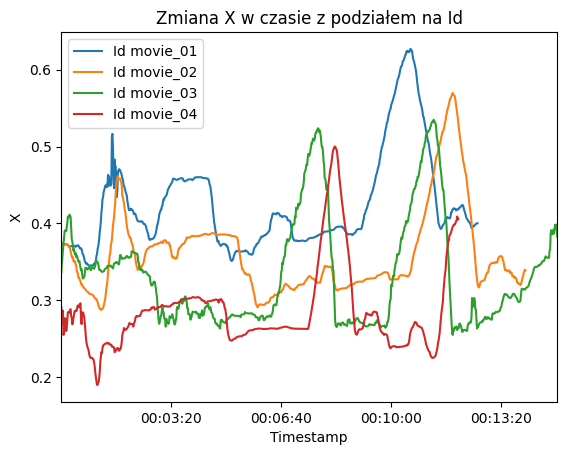

In [11]:
import matplotlib.pyplot as plt

df = dataframe[['Id', 'timestamp', 'nose_y']]

fig, ax = plt.subplots()
for key, group in df.groupby('Id'):
    group.plot(x='timestamp', y='nose_y', ax=ax, label=f'Id {key}')

plt.legend()
plt.title('Zmiana X w czasie z podziałem na Id')
plt.xlabel('Timestamp')
plt.ylabel('X')

plt.show()